Epoch 1/85
160/160 [==============================] - 612s 4s/step - loss: 1.7113 - accuracy: 0.3119 - val_loss: 1.5468 - val_accuracy: 0.3781
Epoch 2/85
160/160 [==============================] - 654s 4s/step - loss: 1.5503 - accuracy: 0.3977 - val_loss: 1.5416 - val_accuracy: 0.4313
Epoch 3/85
160/160 [==============================] - 665s 4s/step - loss: 1.4639 - accuracy: 0.4398 - val_loss: 1.4667 - val_accuracy: 0.4538
Epoch 4/85
160/160 [==============================] - 659s 4s/step - loss: 1.4246 - accuracy: 0.4607 - val_loss: 1.4024 - val_accuracy: 0.4456
Epoch 5/85
160/160 [==============================] - 657s 4s/step - loss: 1.3883 - accuracy: 0.4699 - val_loss: 1.3378 - val_accuracy: 0.5019
Epoch 6/85
160/160 [==============================] - 659s 4s/step - loss: 1.3499 - accuracy: 0.4982 - val_loss: 1.3587 - val_accuracy: 0.4781
Epoch 7/85
160/160 [==============================] - 656s 4s/step - loss: 1.3141 - accuracy: 0.5076 - val_loss: 1.2896 - val_accuracy: 0.5156

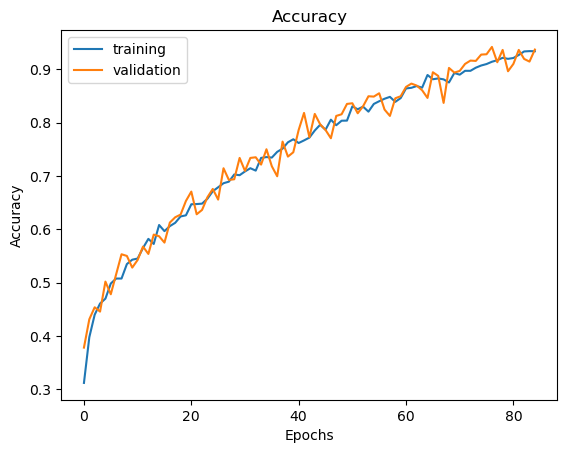

INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets


In [2]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # train-test split을 위해 추가
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# TensorFlow GPU 메모리 동적 관리 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# ResNet-50 모델 불러오기 및 커스터마이징
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 862, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# ResNet-50 기본 모델 레이어를 고정하여 학습되지 않도록 함
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 데이터셋 및 레이블 생성 함수
def generate_data(data_dir, class_labels, batch_size, is_training=True):
    while True:
        batch_X = []
        batch_labels = []
        data_to_use = os.listdir(data_dir)
        
        if is_training:
            data_to_use = train_test_split(data_to_use, test_size=0.2, random_state=42)[0]
        else:
            data_to_use = train_test_split(data_to_use, test_size=0.2, random_state=42)[1]
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # 수정된 부분: class_dir 내에 있는 파일들을 이용해 무작위로 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 모델 학습 및 validation 데이터 사용
batch_size = 32
steps_per_epoch = 160
epochs = 85

# 훈련 데이터셋 생성 함수
train_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=True)

# 테스트 데이터셋 생성 함수
test_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=False)

# 모델 학습
history = model.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=test_data_generator,
    validation_steps=50)

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')  # 검증 데이터 정확도 추가
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Save the model in the recommended format
model.save('resnet.keras')  # Save the entire model (architecture, weights, optimizer state)

# If you prefer to save it using TensorFlow's SavedModel format:
model.save('resnet_model', save_format='tf')

In [3]:
from tensorflow.keras.models import load_model

# 저장된 모델 로드
loaded_model = load_model('resnet.keras')

# 테스트 데이터셋 생성 함수
test_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=False)

# 테스트 데이터로 정확도와 손실 값 계산
test_loss, test_accuracy = loaded_model.evaluate(test_data_generator, steps=50)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# 훈련 및 검증 정확도 및 손실 값 그래프 시각화
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot([epochs - 1], [test_accuracy], marker='o', markersize=8, label='test', color='r')  # 테스트 정확도 마커 추가
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

AttributeError: 'Adam' object has no attribute 'build'

In [7]:
import tensorflow as tf

# .pb 파일 로드
loaded_model = tf.saved_model.load('/Users/jangminjun/Desktop/resnet_model')  # SavedModel 디렉토리를 지정

In [9]:
import tensorflow as tf

# .pb 파일 로드
loaded_model = tf.saved_model.load('/Users/jangminjun/Desktop/resnet_model')

# .h5 파일로 저장
tf.saved_model.save(loaded_model, 'converted_model.h5')

INFO:tensorflow:Assets written to: converted_model.h5/assets


INFO:tensorflow:Assets written to: converted_model.h5/assets


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model

# .pb 파일(SavedModel 형식)에서 모델 로드
loaded_model = tf.keras.models.load_model('/Users/jangminjun/Desktop/resnet_model')

# .h5 형식으로 다시 저장
save_model(loaded_model, 'resnet_v3.h5')

/var/folders/y_/kd9p7gk12s546ns_zynj91lw0000gn/T/ipykernel_41723/1552100565.py:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(loaded_model, 'resnet_v3.h5')


In [12]:
import tensorflow as tf
import numpy as np

# 모델 로드
loaded_model = tf.keras.models.load_model('/Users/jangminjun/Desktop/resnet_v3.h5')

In [13]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 862, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 868, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 431, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 431, 64)          256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [14]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

31/31 [==============================] - 87s 3s/step - loss: 0.2951 - accuracy: 0.9395
Loss: 0.2951
Accuracy: 93.95%


In [18]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

31/31 [==============================] - 85s 3s/step - loss: 0.3044 - accuracy: 0.9466
Loss: 0.3044
Accuracy: 94.66%


In [19]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}%")

31/31 [==============================] - 86s 3s/step - loss: 0.2916 - accuracy: 0.9466
Loss: 0.2916
Accuracy: 0.95%


In [20]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

31/31 [==============================] - 86s 3s/step - loss: 0.3067 - accuracy: 0.9395
Loss: 0.30668
Accuracy: 0.93952%


In [21]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf



# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

31/31 [==============================] - 91s 3s/step - loss: 0.2893 - accuracy: 0.9375
Loss: 0.28934
Accuracy: 0.93750


In [23]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 500  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

15/15 [==============================] - 43s 3s/step - loss: 0.2662 - accuracy: 0.9646
Loss: 0.26615
Accuracy: 0.96458


In [24]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random

# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 500  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

15/15 [==============================] - 42s 3s/step - loss: 0.2808 - accuracy: 0.9458
Loss: 0.28077
Accuracy: 0.94583


In [25]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random

# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 500  # 한 번에 사용할 테스트 샘플 수입니다. 이 값을 데이터셋 크기에 맞게 조절하세요.
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

15/15 [==============================] - 43s 3s/step - loss: 0.2808 - accuracy: 0.9458
Loss: 0.28077
Accuracy: 0.94583


In [27]:
import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random

# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet_v3.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

31/31 [==============================] - 87s 3s/step - loss: 0.2804 - accuracy: 0.9425
Loss: 0.28042
Accuracy: 0.94254


In [28]:
#예전에 썼던 모델

import os
import glob
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random

# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model_path = '/Users/jangminjun/Desktop/resnet.h5'
model = load_model(model_path)

# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

31/31 [==============================] - 98s 3s/step - loss: 0.3560 - accuracy: 0.9204
Loss: 0.35596
Accuracy: 0.92036


In [29]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import load_model

loaded_model = load_model('/Users/jangminjun/Desktop/resnet_v3.h5')
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# 테스트 데이터셋 생성 함수
def generate_test_data(data_dir, class_labels, batch_size):
    while True:
        batch_X = []
        batch_labels = []
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # class_dir 내에 있는 파일들을 이용해 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 테스트 데이터셋 생성 함수 사용
test_batch_size = 32
test_data_generator = generate_test_data(data_dir, class_labels, test_batch_size)

# 모델 평가
num_test_samples = len(class_labels) * test_batch_size  # 전체 테스트 샘플 수 계산
num_test_batches = int(np.ceil(num_test_samples / test_batch_size))  # 테스트 배치 수 계산
evaluation = loaded_model.evaluate(test_data_generator, steps=num_test_batches)
print("평가 결과:", evaluation)

7/7 [==============================] - 24s 3s/step - loss: 0.3007 - accuracy: 0.9464
평가 결과: [0.30069679021835327, 0.9464285969734192]


In [31]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import load_model
import random

# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

loaded_model = load_model('/Users/jangminjun/Desktop/resnet_v3.h5')
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# 테스트 데이터셋 생성 함수
def generate_test_data(data_dir, class_labels, batch_size):
    while True:
        batch_X = []
        batch_labels = []
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # class_dir 내에 있는 파일들을 이용해 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 테스트 데이터셋 생성 함수 사용
test_batch_size = 32
test_data_generator = generate_test_data(data_dir, class_labels, test_batch_size)

# 모델 평가
num_test_samples = len(class_labels) * test_batch_size  # 전체 테스트 샘플 수 계산
num_test_batches = int(np.ceil(num_test_samples / test_batch_size))  # 테스트 배치 수 계산
evaluation = loaded_model.evaluate(test_data_generator, steps=num_test_batches)
print("평가 결과:", evaluation)

7/7 [==============================] - 20s 3s/step - loss: 0.3031 - accuracy: 0.9464
평가 결과: [0.3031439483165741, 0.9464285969734192]


In [32]:
#예전모델

import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import load_model
import random

# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

loaded_model = load_model('/Users/jangminjun/Desktop/resnet.h5')
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# 테스트 데이터셋 생성 함수
def generate_test_data(data_dir, class_labels, batch_size):
    while True:
        batch_X = []
        batch_labels = []
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # class_dir 내에 있는 파일들을 이용해 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 테스트 데이터셋 생성 함수 사용
test_batch_size = 32
test_data_generator = generate_test_data(data_dir, class_labels, test_batch_size)

# 모델 평가
num_test_samples = len(class_labels) * test_batch_size  # 전체 테스트 샘플 수 계산
num_test_batches = int(np.ceil(num_test_samples / test_batch_size))  # 테스트 배치 수 계산
evaluation = loaded_model.evaluate(test_data_generator, steps=num_test_batches)
print("평가 결과:", evaluation)

7/7 [==============================] - 20s 3s/step - loss: 0.3668 - accuracy: 0.9062
평가 결과: [0.3667914867401123, 0.90625]
